In [1]:
"""
한국어 감성 분석
RNN과 자연어 처리 방법을 활용해 텍스트 데이터에서 긍정 또는 부정 감정을 
분류하는 예제를 살펴본다

"""
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
"""
텍스트 분류에서 사용할 데이터 셋은 네이버 영화 리뷰 데이터이다
총 200,000개의 데이터가 있으며 훈련(train)데이터로 150,000개 
테스트(test)데이터가 50,000개로 구성되어 있다
모든 리뷰의 길이는 140자 이내이며, 실제 영화 리뷰 점수는 1점에서 10점으로 이루어져 있다
9~10점을 긍정적 리뷰, 1~4점을 부정적 리뷰로 분류한 데이터이다 (5~8점은 포함하지 않음)

먼저 train 데이터를 다운로드한 후 데이터프레임으로 저장한다 
이때 데이터셋은 txt 파일이며 탭(Tap)으로 컬럼(열)이 구분되어 있어 구분자를 sep ="\t"으로
설정한다
텐서플로에서 제공하고 있는 get_file()함수를 사용하면 URL로부터 다운로드가 가능하다
"""
# Naver sentiment movie corpus v1.0 데이터셋 불러오기
train_file = tf.keras.utils.get_file(
    'ratings_train.txt', 
    origin='https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt', 
    extract=True)

train = pd.read_csv(train_file, sep="\t")

In [3]:
"""
EDA (탐색적 데이터 분석)
간단한 탐색적 데이터 분석(EDA)를 통해 데이터 파악 및 전처리가 필요한 부분을 찾아본다
데이터 크기 및 샘플 확인, 레이블 비율, 결측치, 각 레이블별 텍스트 길이 등을 확인한다
train 데이터 크기(150000, 3 )이다
데이터 샘플을 살펴보면 id, documment, label로 구성되어 있음을 확인할 수 있다
감성분석을 위한 텍스트 분류 모델에서 필요한 값은 document 와 label이다
"""
# 데이터 크기 및 샘플 확인
print("train shape:", train.shape)
train.head()

train shape: (150000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
"""
label 열에 들어 있는 긍정 또는 부정의 비율을 비교한다
0(부정) : 75,173개와 1(긍정) : 74,827개로 비슷한 비율로 구성되었음을 확인할 수 있다
"""
#레이블별 개수
cnt = train["label"].value_counts()
print(cnt)

0    75173
1    74827
Name: label, dtype: int64


<AxesSubplot:xlabel='label', ylabel='count'>

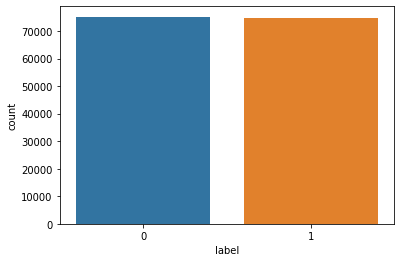

In [6]:
"""
seaborn 라이브러리의 countplot()함수로 시각화
"""
# 레이블별 비율
sns.countplot(x = "label", data=train)

In [7]:
"""
데이터셋의 결측치를 확인해 보자
document에 5개의 빈 값이 보인다 
빈 값은 부정일 수도 있고 긍정일 수도 있어
label 값과 비교해볼 필요가 있다
"""
#결측치 확인
train.isnull().sum()

id          0
document    5
label       0
dtype: int64

In [9]:
"""
리뷰 글이 없는(빈 글) 데이터는 특정 label 값만 있는 것이 아니라 긍정과 부정이
섞여 있음을 확인할 수 있다
의미가 없는 데이터이므로 결측치가 있는 행은 추후 삭제하기로 한다
"""
# 결측치(의견 없음)가 특정 label 값만 있는지 확인
train[train["document"].isnull()]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


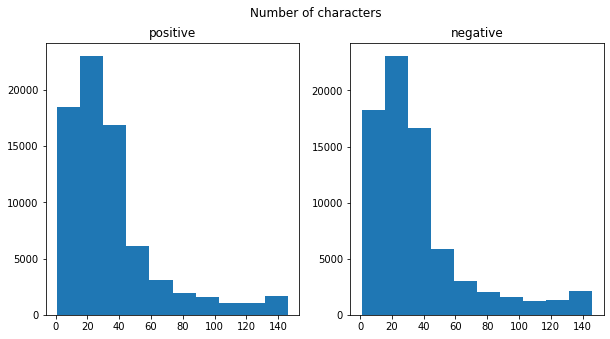

In [12]:
"""
긍정과 부정에 따른 데이터의 길이 차이가 있는지 확인해보자. 
예를 들어 긍정적인 감정을 가지고 있다면 감탄사만 나열해 짧게 작성하거나
구체적인 감정을 길게 작성하는 특징이 있을 수도 있다는 가설을 세우고,
이를 확인하기 위해 시각화해서 체크해볼 수 있다
"""
# 레이블별 텍스트 길이
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
data_len = train[train["label"]==1]["document"].str.len()
ax1.hist(data_len)
ax1.set_title("positive")

data_len = train[train["label"]==0]["document"].str.len()
ax2.hist(data_len)
ax2.set_title("negative")
fig.suptitle("Number of characters")
plt.show()

In [ ]:
"""
긍정과 부정의 차이가 거의 없음을 확인함
"""

In [13]:
"""
4-2-3 형태소 분석기 불러오기
여러 가지 한국어 형태소 분석기가 개발되어 있다 Kkma, Komoran, Okt, Mecab 등을 예로 들 수 있따
영어는 띄어쓰기가 잘 되어 있는 편이지만 한글은 띄어쓰기, 맞춤법 등이 잘못된 경우 
분리에 어려움이 있따 
한편, 정확한 형태소 분석을 위해서는 데이터에 따라 전처리 과정 등이 필요할 수도 있다
"""
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

Cloning into 'Mecab-ko-for-Google-Colab'...


In [14]:
cd Mecab-ko-for-Google-Colab/

C:\jupyter_project\playdata_2021_06\tensorflow_자격증\Mecab-ko-for-Google-Colab


In [15]:
! bash install_mecab-ko_on_colab190912.sh

In [16]:
# Kkma, Komoran, Okt, Mecab 형태소
import konlpy
from konlpy.tag import Kkma, Komoran, Okt, Mecab

kkma = Kkma()
komoran = Komoran()
okt = Okt()
mecab = Mecab()


ModuleNotFoundError: No module named 'konlpy'

In [ ]:
"""
모듈때문에 코랩으로 넘어감
"""